In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import RFE
import xgboost as xgb
from xgboost import XGBClassifier
from scipy.stats import uniform, randint

In [4]:
df = pd.read_csv('Credit Card Defaulter.csv')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,F,University,Married,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,Y
1,2,120000,F,University,Single,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,Y
2,3,90000,F,University,Single,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,N
3,4,50000,F,University,Married,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,N
4,5,50000,M,University,Married,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,N


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         30000 non-null  int64 
 1   LIMIT_BAL  30000 non-null  int64 
 2   SEX        30000 non-null  object
 3   EDUCATION  30000 non-null  object
 4   MARRIAGE   30000 non-null  object
 5   AGE        30000 non-null  int64 
 6   PAY_0      30000 non-null  int64 
 7   PAY_2      30000 non-null  int64 
 8   PAY_3      30000 non-null  int64 
 9   PAY_4      30000 non-null  int64 
 10  PAY_5      30000 non-null  int64 
 11  PAY_6      30000 non-null  int64 
 12  BILL_AMT1  30000 non-null  int64 
 13  BILL_AMT2  30000 non-null  int64 
 14  BILL_AMT3  30000 non-null  int64 
 15  BILL_AMT4  30000 non-null  int64 
 16  BILL_AMT5  30000 non-null  int64 
 17  BILL_AMT6  30000 non-null  int64 
 18  PAY_AMT1   30000 non-null  int64 
 19  PAY_AMT2   30000 non-null  int64 
 20  PAY_AMT3   30000 non-null  i

In [6]:
df.drop(['ID'], axis=1, inplace= True)

In [7]:
df['default'] = df['default'].replace({'Y': 1, 'N': 0})

In [8]:
df['PAY_0'] = df['PAY_0'].astype('object')
df['PAY_2'] = df['PAY_2'].astype('object')
df['PAY_3'] = df['PAY_3'].astype('object')
df['PAY_4'] = df['PAY_4'].astype('object')
df['PAY_5'] = df['PAY_5'].astype('object')
df['PAY_6'] = df['PAY_6'].astype('object')
#df['default'] = df['default'].astype('object')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   LIMIT_BAL  30000 non-null  int64 
 1   SEX        30000 non-null  object
 2   EDUCATION  30000 non-null  object
 3   MARRIAGE   30000 non-null  object
 4   AGE        30000 non-null  int64 
 5   PAY_0      30000 non-null  object
 6   PAY_2      30000 non-null  object
 7   PAY_3      30000 non-null  object
 8   PAY_4      30000 non-null  object
 9   PAY_5      30000 non-null  object
 10  PAY_6      30000 non-null  object
 11  BILL_AMT1  30000 non-null  int64 
 12  BILL_AMT2  30000 non-null  int64 
 13  BILL_AMT3  30000 non-null  int64 
 14  BILL_AMT4  30000 non-null  int64 
 15  BILL_AMT5  30000 non-null  int64 
 16  BILL_AMT6  30000 non-null  int64 
 17  PAY_AMT1   30000 non-null  int64 
 18  PAY_AMT2   30000 non-null  int64 
 19  PAY_AMT3   30000 non-null  int64 
 20  PAY_AMT4   30000 non-null  i

In [10]:
df.default.value_counts()

0    23364
1     6636
Name: default, dtype: int64

In [11]:
df['PAY_0'].value_counts()

 0    14737
-1     5686
 1     3688
-2     2759
 2     2667
 3      322
 4       76
 5       26
 8       19
 6       11
 7        9
Name: PAY_0, dtype: int64

# EDA

In [263]:
df_num = df.select_dtypes(include="number")
df_num.describe()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
count,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,35.485500,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,9.217904,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,21.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,28.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,34.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,41.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,79.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


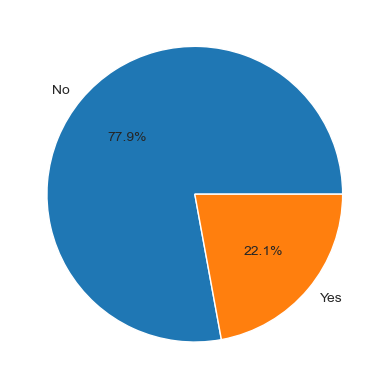

In [264]:
inter=df['default'].value_counts()
plt.pie(inter,labels=['No','Yes'],autopct='%0.1f%%',radius=1);
plt.show()

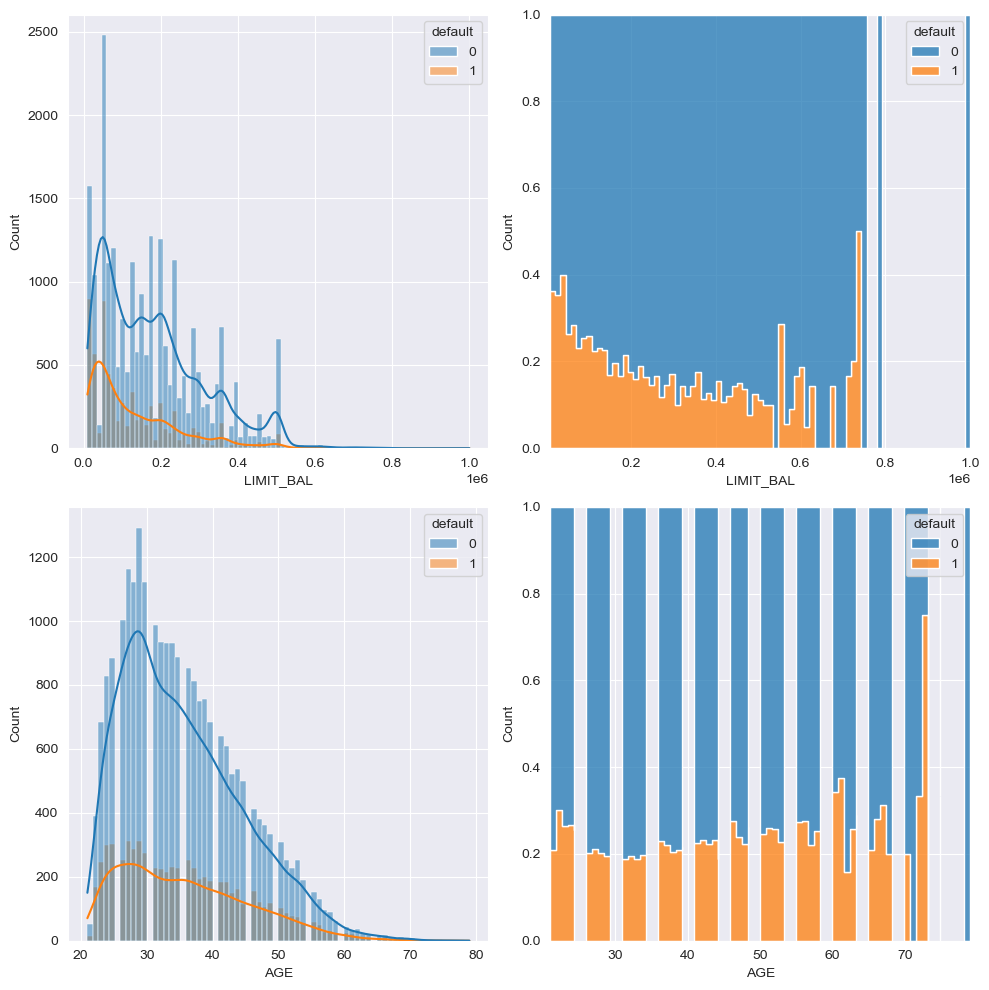

In [252]:
fig,axes=plt.subplots(2,2,figsize=(10,10))
cols=['LIMIT_BAL','AGE']
for i,col in enumerate(cols):
    if col=='PAY_AMT1':
        x=np.log1p(df[col])
    else:
        x=df[col]
        
    sns.histplot(x=x,hue='default',data=df,kde=True,ax=axes[i,0]);
    sns.histplot(x=x,hue='default',data=df,multiple="fill",ax=axes[i,1],element="step");
    
plt.tight_layout()
plt.show()

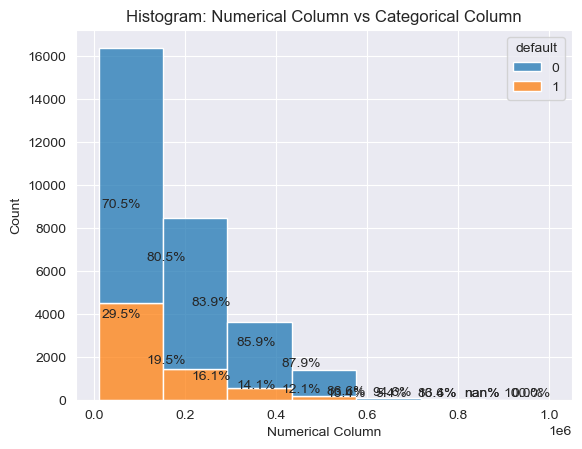

In [271]:
sns.histplot(data=df, x='LIMIT_BAL', bins=7, hue='default', multiple='stack')

# Calculate the percentage for each class
class_counts = df.groupby(['default', pd.cut(df['LIMIT_BAL'], bins=10)])['LIMIT_BAL'].count()
total_counts = class_counts.sum(level=1)

for class_label in df['default'].unique():
    percentages = (class_counts[class_label] / total_counts) * 100
    for x, y in zip(class_counts[class_label].index, class_counts[class_label].values):
        plt.text(x.mid, y, f'{percentages[x.mid]:.1f}%', ha='center', va='bottom')

# Set labels and title
plt.xlabel('Numerical Column')
plt.ylabel('Count')
plt.title('Histogram: Numerical Column vs Categorical Column')

# Show the plot
plt.show()

In [ ]:
#Proportion of default reduces with increase in card limit

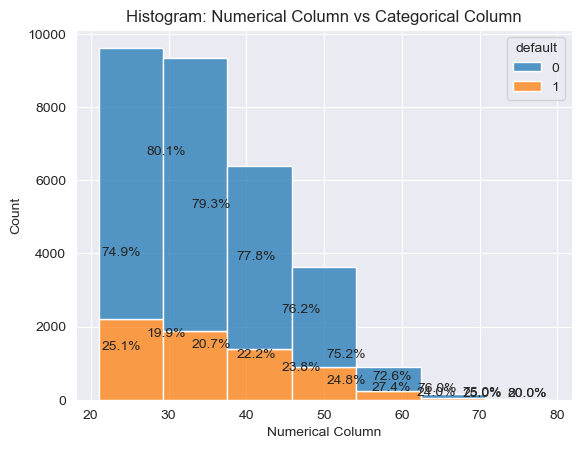

In [272]:
sns.histplot(data=df, x='AGE', bins=7, hue='default', multiple='stack')

# Calculate the percentage for each class
class_counts = df.groupby(['default', pd.cut(df['AGE'], bins=10)])['AGE'].count()
total_counts = class_counts.sum(level=1)

for class_label in df['default'].unique():
    percentages = (class_counts[class_label] / total_counts) * 100
    for x, y in zip(class_counts[class_label].index, class_counts[class_label].values):
        plt.text(x.mid, y, f'{percentages[x.mid]:.1f}%', ha='center', va='bottom')

# Set labels and title
plt.xlabel('Numerical Column')
plt.ylabel('Count')
plt.title('Histogram: Numerical Column vs Categorical Column')

# Show the plot
plt.show()


In [ ]:
#Proportion of default reduces with increase in age

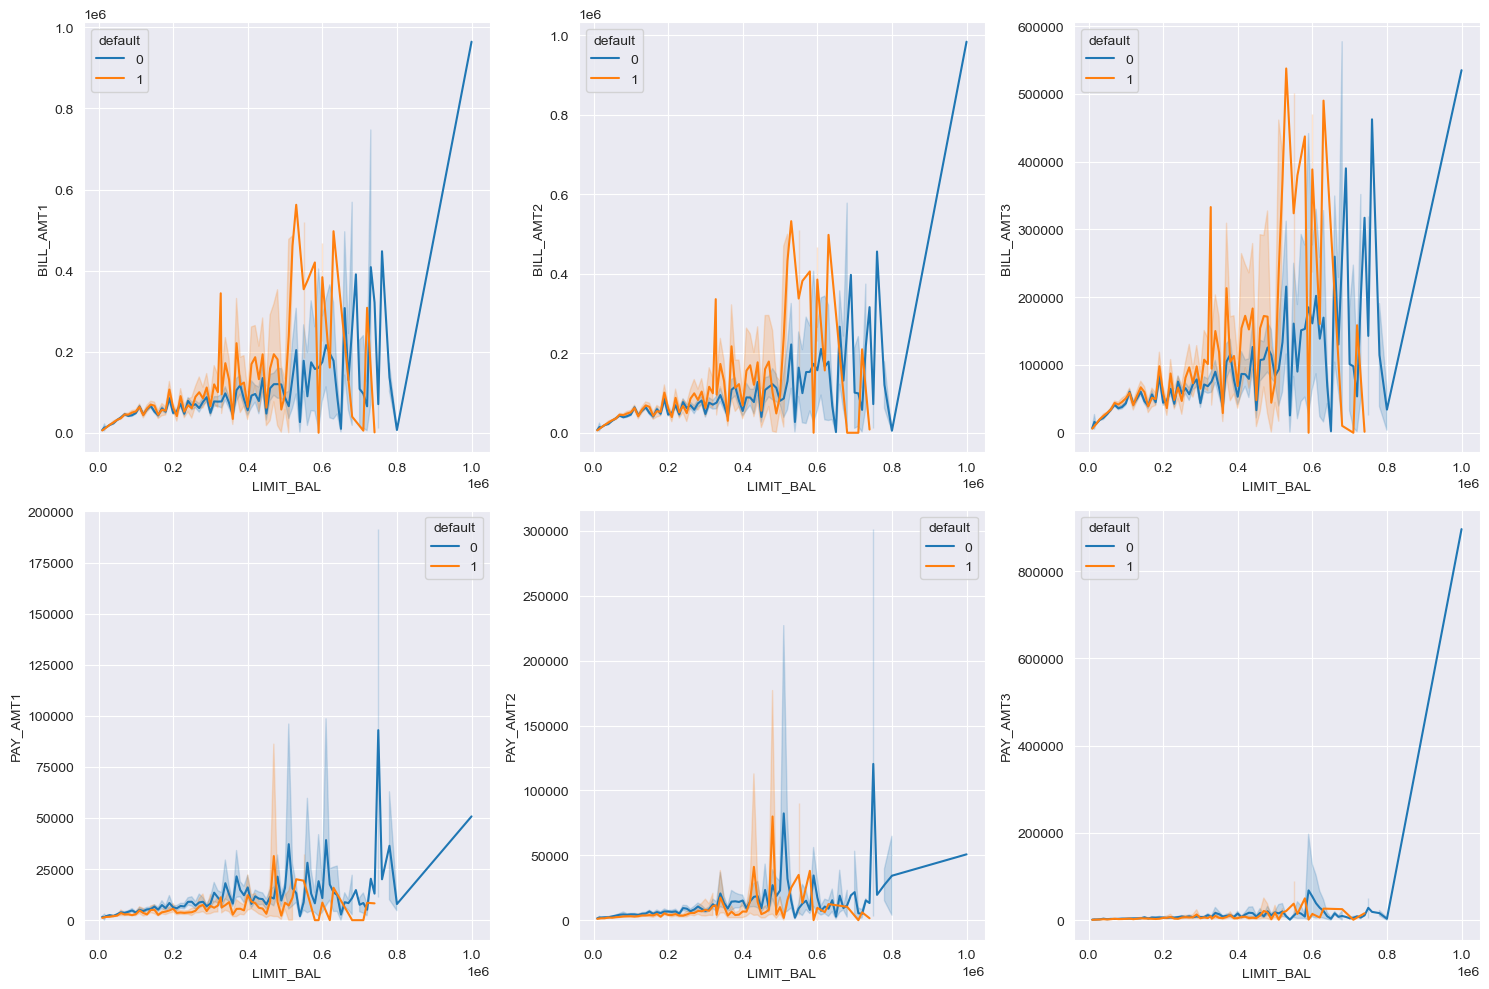

In [276]:
fig,axes=plt.subplots(2,3,figsize=(15,10))
cols=['BILL_AMT', 'PAY_AMT']
for i,col in enumerate(cols):
    for j in range(1,4):
        inter=col+str(j)
    
        sns.lineplot(x='LIMIT_BAL',y=inter, hue="default",data=df,ax=axes[i,j-1]);
    
plt.tight_layout()

In [ ]:
#Card Holders with high PAY AMOUNT have lower default then with low PAY AMOUNT

In [283]:
df.corr()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
LIMIT_BAL,1.000000,0.144713,0.285430,0.278314,0.283236,0.293988,0.295562,0.290389,0.195236,0.178408,0.210167,0.203242,0.217202,0.219595,-0.153520
AGE,0.144713,1.000000,0.056239,0.054283,0.053710,0.051353,0.049345,0.047613,0.026147,0.021785,0.029247,0.021379,0.022850,0.019478,0.013890
BILL_AMT1,0.285430,0.056239,1.000000,0.951484,0.892279,0.860272,0.829779,0.802650,0.140277,0.099355,0.156887,0.158303,0.167026,0.179341,-0.019644
BILL_AMT2,0.278314,0.054283,0.951484,1.000000,0.928326,0.892482,0.859778,0.831594,0.280365,0.100851,0.150718,0.147398,0.157957,0.174256,-0.014193
BILL_AMT3,0.283236,0.053710,0.892279,0.928326,1.000000,0.923969,0.883910,0.853320,0.244335,0.316936,0.130011,0.143405,0.179712,0.182326,-0.014076
BILL_AMT4,0.293988,0.051353,0.860272,0.892482,0.923969,1.000000,0.940134,0.900941,0.233012,0.207564,0.300023,0.130191,0.160433,0.177637,-0.010156
BILL_AMT5,0.295562,0.049345,0.829779,0.859778,0.883910,0.940134,1.000000,0.946197,0.217031,0.181246,0.252305,0.293118,0.141574,0.164184,-0.006760
BILL_AMT6,0.290389,0.047613,0.802650,0.831594,0.853320,0.900941,0.946197,1.000000,0.199965,0.172663,0.233770,0.250237,0.307729,0.115494,-0.005372
PAY_AMT1,0.195236,0.026147,0.140277,0.280365,0.244335,0.233012,0.217031,0.199965,1.000000,0.285576,0.252191,0.199558,0.148459,0.185735,-0.072929
PAY_AMT2,0.178408,0.021785,0.099355,0.100851,0.316936,0.207564,0.181246,0.172663,0.285576,1.000000,0.244770,0.180107,0.180908,0.157634,-0.058579


In [ ]:
#Repayment Status variables have strong correlation with the previous months repayment status variables.
#Bill_AMT variables are highly correlated, as the Bill_AMT depends on previous money owned plus money
#drawn present month due to which it has string correlation with previous month Bill_AMT.

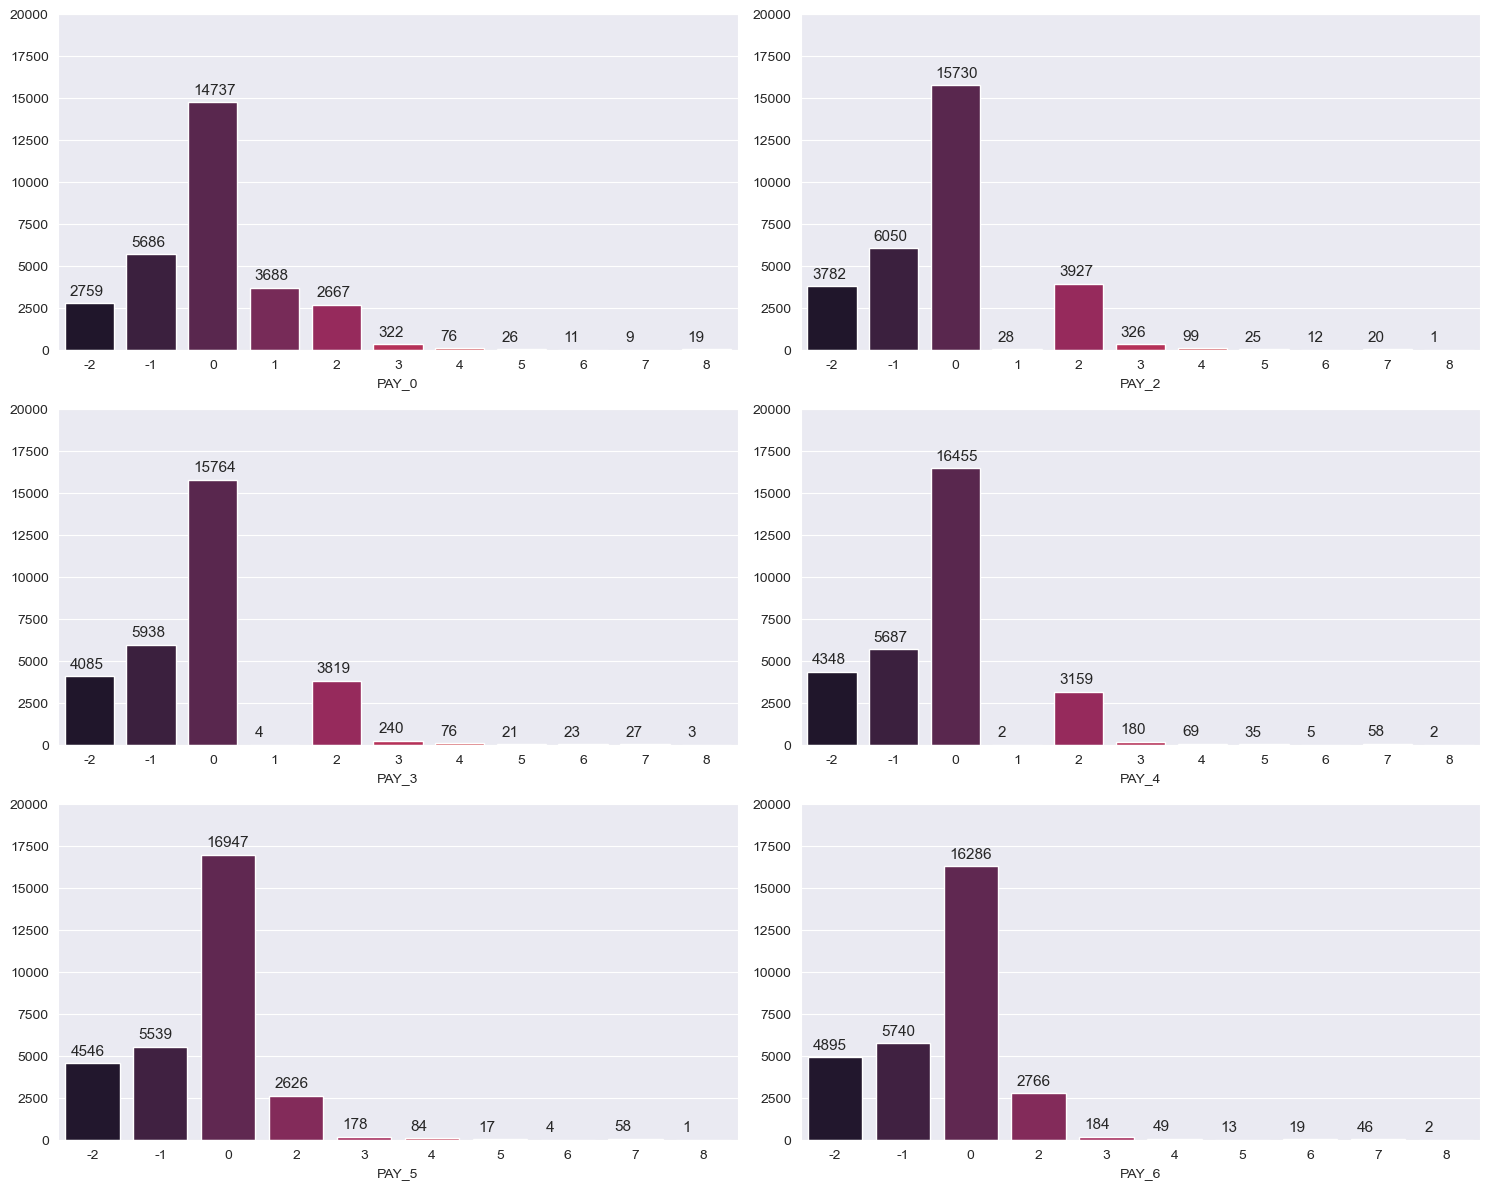

In [222]:
pay_x_fts = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
plt.figure(figsize=(15,12))

for i,col in enumerate(pay_x_fts):    
    plt.subplot(3,2,i + 1)
    ax = sns.countplot(df.loc[:,col], palette = 'rocket')
    plt.ylim(0,20000)
    plt.ylabel('')
    plt.tight_layout()
    
    for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.08, p.get_height()+500), fontsize = 11)

plt.show()

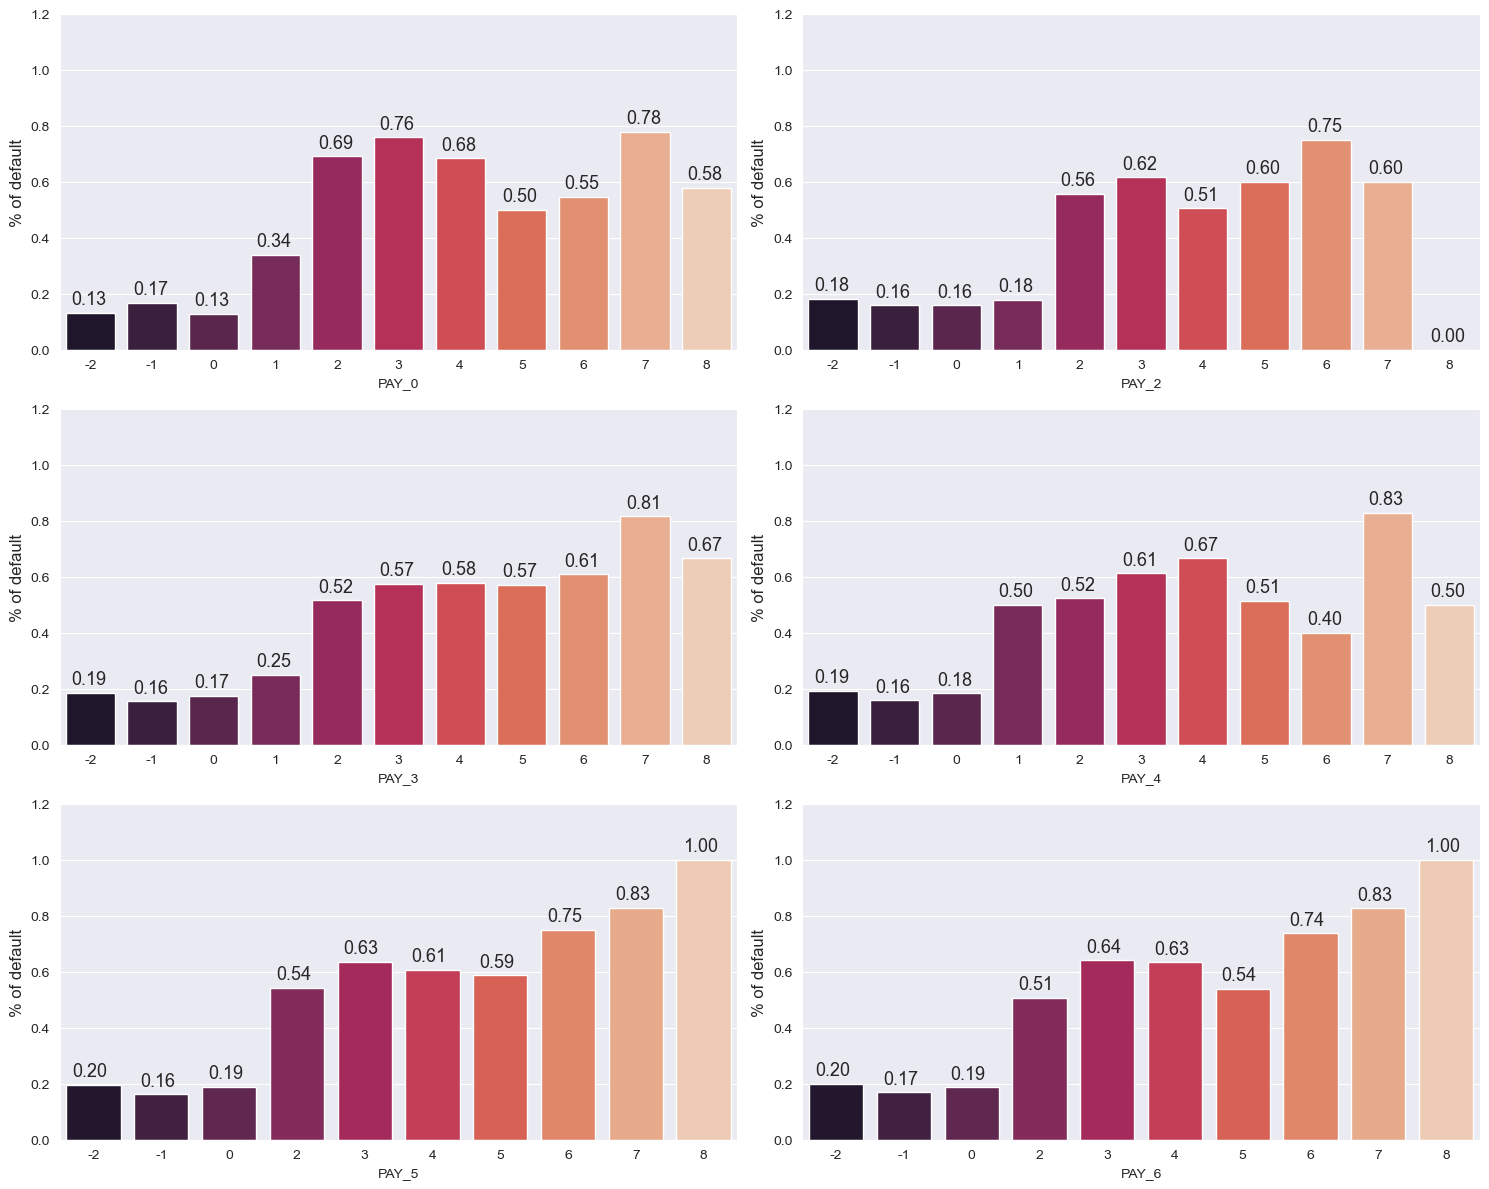

In [190]:
plt.figure(figsize=(15,12))

for i,col in enumerate(pay_x_fts):    
    plt.subplot(3,2,i + 1)
    ax = sns.barplot(x = col, y = "default", data = df, palette = 'rocket', ci = None)
    plt.ylabel("% of default", fontsize= 12)
    plt.ylim(0,1.2)
    plt.tight_layout()
    
    for p in ax.patches:
        ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.09, p.get_height()+0.03),fontsize=13)

plt.show()

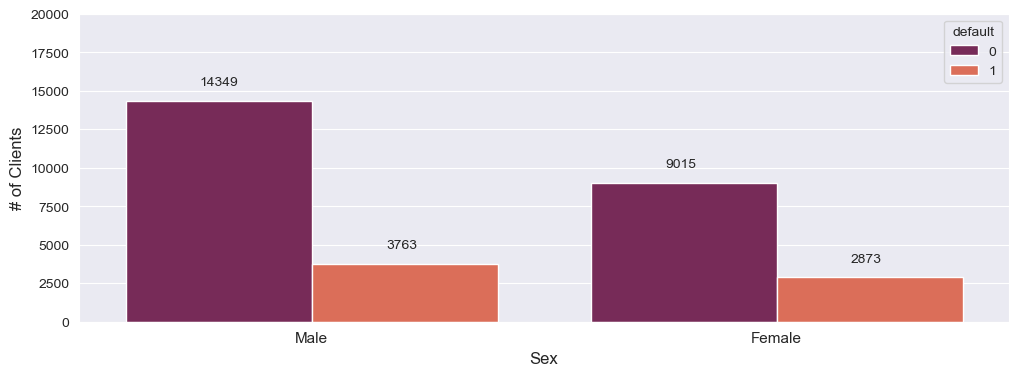

In [191]:
plt.figure(figsize=(12,4))

ax = sns.countplot(data = df, x = 'SEX', hue="default", palette = 'rocket')

plt.xlabel("Sex", fontsize= 12)
plt.ylabel("# of Clients", fontsize= 12)
plt.ylim(0,20000)
plt.xticks([0,1],['Male', 'Female'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.16, p.get_height()+1000))

plt.show()

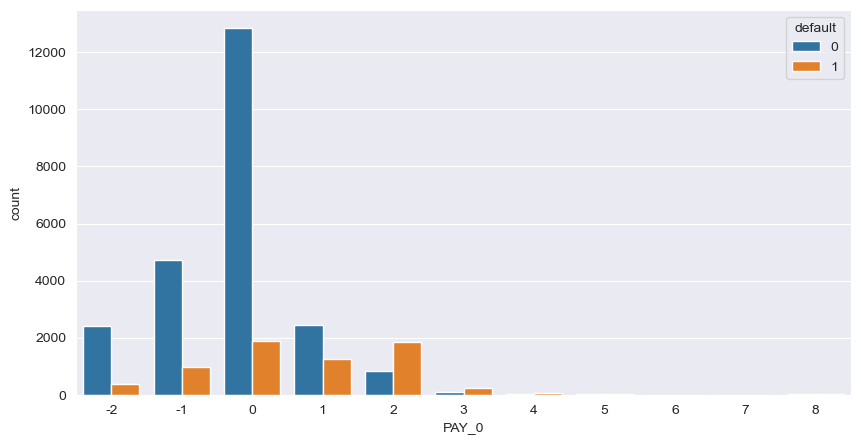

In [192]:
plt.figure(figsize=(10,5))
sns.countplot(x = 'PAY_0', hue = 'default', data = df);

# Checking for Multicollinearity 

In [12]:
df_num = df[['LIMIT_BAL','AGE','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6',
             'PAY_AMT1','PAY_AMT2', 'PAY_AMT3','PAY_AMT4', 'PAY_AMT5','PAY_AMT6']]

In [13]:
#X_train_ols = sm.add_constant(df_num)
df_num_vif = sm.add_constant(df_num)

In [14]:
vif = pd.DataFrame()
vif['Feature'] = df_num_vif.columns
vif['VIF'] = [variance_inflation_factor(df_num_vif.values, i) for i in range(df_num_vif.shape[1])]

# Print the VIF values
print(vif)

      Feature        VIF
0       const  16.462977
1   LIMIT_BAL   1.230768
2         AGE   1.022211
3   BILL_AMT1  13.914295
4   BILL_AMT2  25.760114
5   BILL_AMT3  21.727446
6   BILL_AMT4  20.247252
7   BILL_AMT5  24.886076
8   BILL_AMT6  14.927201
9    PAY_AMT1   1.691400
10   PAY_AMT2   2.222764
11   PAY_AMT3   1.735050
12   PAY_AMT4   1.629473
13   PAY_AMT5   1.678846
14   PAY_AMT6   1.169004


In [15]:
df_num = df[['LIMIT_BAL','AGE','BILL_AMT2','BILL_AMT4','BILL_AMT6',
             'PAY_AMT1','PAY_AMT2', 'PAY_AMT3','PAY_AMT4', 'PAY_AMT5','PAY_AMT6']]
df_num_vif = sm.add_constant(df_num)

In [16]:
vif = pd.DataFrame()
vif['Feature'] = df_num_vif.columns
vif['VIF'] = [variance_inflation_factor(df_num_vif.values, i) for i in range(df_num_vif.shape[1])]

# Print the VIF values
print(vif)

      Feature        VIF
0       const  16.461220
1   LIMIT_BAL   1.222509
2         AGE   1.022074
3   BILL_AMT2   6.035605
4   BILL_AMT4  11.431831
5   BILL_AMT6   7.495998
6    PAY_AMT1   1.277885
7    PAY_AMT2   1.243594
8    PAY_AMT3   1.364046
9    PAY_AMT4   1.279651
10   PAY_AMT5   1.325928
11   PAY_AMT6   1.150932


# Processing Dataset

In [17]:
X = df.drop(['BILL_AMT1','BILL_AMT3','BILL_AMT5','default'], axis=1)
y = df['default']
X.shape

(30000, 20)

In [18]:
def scale_encode_data(df):
    df_num = df.select_dtypes(include="number")
    df_cat = df.select_dtypes(include="object")
    
    #mmscaler = MinMaxScaler()
    #df_num_rescaled = pd.DataFrame(mmscaler.fit_transform(df_num), columns=df_num.columns)
    
    OHE = OneHotEncoder(drop='first')
    df_cat_ohe = pd.DataFrame(OHE.fit_transform(df_cat).toarray(), columns=OHE.get_feature_names_out())
    
    df_num.reset_index(drop=True, inplace=True)
    df_cat_ohe.reset_index(drop=True, inplace=True)
    df_enc = pd.concat([df_num, df_cat_ohe], axis = 1)
    
    return df_enc

In [19]:
X = scale_encode_data(X)
X.shape

(30000, 78)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, X_test.shape

((24000, 78), (6000, 78))

# Logistic Regression

In [202]:
X_train.shape, X_test.shape

((24000, 78), (6000, 78))

In [203]:
X_train_log = sm.add_constant(X_train)

In [204]:
pd.DataFrame(X_train.sum(axis=0)).tail(50)

,0
PAY_0_7,9.0
PAY_0_8,15.0
PAY_2_-1,4862.0
PAY_2_0,12572.0
PAY_2_1,25.0
PAY_2_2,3154.0
PAY_2_3,270.0
PAY_2_4,85.0
PAY_2_5,21.0
PAY_2_6,11.0


In [205]:
X_train_log = X_train_log.drop(['PAY_2_8','PAY_5_8','PAY_6_8','PAY_5_6','PAY_4_8','PAY_4_6','PAY_4_1','PAY_3_8',
                                'PAY_3_1','PAY_0_7'], axis=1)

In [206]:
X_train_log = X_train_log.drop(['PAY_0_8','PAY_2_1','PAY_2_5','PAY_2_6','PAY_3_6','PAY_4_5',
                                 'PAY_6_5','PAY_6_6'], axis=1)

In [207]:
logmodel = sm.Logit(y_train,X_train_log)
results = logmodel.fit()

         Current function value: 0.435414
         Iterations: 35


In [208]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                24000
Model:                          Logit   Df Residuals:                    23939
Method:                           MLE   Df Model:                           60
Date:                Tue, 27 Jun 2023   Pseudo R-squ.:                  0.1785
Time:                        15:18:31   Log-Likelihood:                -10450.
converged:                      False   LL-Null:                       -12720.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                       -16.1403    568.775     -0.028      0.977   -1130.920    1098.639
LIMIT_BAL                 -1.831e-06   1.93e-07     -9.468      0.000   -2.21e-06   -1.45e-06
AGE                           0.0044      0.002      1.996      0.046    8.04e-05       0.009
BILL_AMT2                  1.266e-06   7.66e-07      1.651      0.099   -2.36e-07    2.77e-06
BILL_AMT4                  1.869e-06   1.13e-06      1.648      0.099   -3.54e-07    4.09e-06
BILL_AMT6                 -6.456e-07   9.27e-07     -0.697      0.486   -2.46e-06    1.17e-06
PAY_AMT1                   -1.39e-05   2.65e-06     -5.248      0.000   -1.91e-05   -8.71e-06
PAY_AMT2                  -7.923e-06   2.16e-06     -3.672      0.000   -1.22e-05   -3.69e-06
PAY_AMT3                  -2.809e-06   1.72e-06     -1.634      0.102   -6.18e-06     5.6e-07
PAY_AMT4                  -2.671e-06   1.89e-06     -1.413      0.158   -6.38e-06    1.03e-06
PAY_AMT5                   -6.87e-07   1.66e-06     -0.415      0.678   -3.93e-06    2.56e-06
PAY_AMT6                  -3.759e-06   1.55e-06     -2.431      0.015   -6.79e-06   -7.28e-07
SEX_M                         0.1776      0.036      4.937      0.000       0.107       0.248
EDUCATION_Graduate school    13.3822    568.775      0.024      0.981   -1101.396    1128.161
EDUCATION_High School        13.3075    568.775      0.023      0.981   -1101.471    1128.086
EDUCATION_Others             12.3435    568.775      0.022      0.983   -1102.435    1127.123
EDUCATION_University         13.4038    568.775      0.024      0.981   -1101.375    1128.183
EDUCATION_Unknown            12.2296    568.775      0.022      0.983   -1102.549    1127.008
MARRIAGE_Married              1.4495      0.588      2.467      0.014       0.298       2.601
MARRIAGE_Other                1.4937      0.609      2.453      0.014       0.300       2.687
MARRIAGE_Single               1.2573      0.588      2.139      0.032       0.105       2.409
PAY_0_-1                      0.4607      0.120      3.855      0.000       0.226       0.695
PAY_0_0                      -0.2975      0.129     -2.300      0.021      -0.551      -0.044
PAY_0_1                       0.7694      0.093      8.239      0.000       0.586       0.952
PAY_0_2                       1.9363      0.117     16.490      0.000       1.706       2.166
PAY_0_3                       1.8767      0.185     10.119      0.000       1.513       2.240
PAY_0_4                       1.7047      0.323      5.284      0.000       1.072       2.337
PAY_0_5                       1.3937      0.505      2.759      0.006       0.404       2.384
PAY_0_6                       0.7337      0.729      1.007      0.314      -0.695       2.162
PAY_2_-1                     -0.2243      0.125     -1.801      0.072      -0.468       0.020
PAY_2_0                       0.0125      0.151      0.083      0.934      -0.284       0.309
PAY_2_2                       0.0188      0.1

In [209]:
y_train.value_counts()

0    18661
1     5339
Name: default, dtype: int64

In [210]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [211]:
accuracy_score(y_test, y_pred)

0.7838333333333334

In [212]:
X_train.shape

(24000, 78)

In [213]:
from sklearn.feature_selection import RFECV
clf = LogisticRegression(random_state=42)
rfecv = RFECV(estimator=clf, cv=5)
rfecv.fit(X_train, y_train)
print("Optimal number of features: ", rfecv.n_features_)

Optimal number of features:  26


In [217]:
selected_features = [X.columns[i] for i in range(len(X.columns)) if rfecv.support_[i]]
print("Selected features: ", selected_features)

Selected features:  ['EDUCATION_Graduate school', 'EDUCATION_High School', 'EDUCATION_Others', 'EDUCATION_University', 'EDUCATION_Unknown', 'MARRIAGE_Married', 'MARRIAGE_Other', 'MARRIAGE_Single', 'PAY_0_0', 'PAY_0_1', 'PAY_0_2', 'PAY_0_3', 'PAY_0_4', 'PAY_2_0', 'PAY_2_2', 'PAY_2_3', 'PAY_3_2', 'PAY_3_3', 'PAY_4_2', 'PAY_4_3', 'PAY_4_4', 'PAY_5_2', 'PAY_5_3', 'PAY_5_7', 'PAY_6_0', 'PAY_6_3']


In [218]:
X_train_selected = rfecv.transform(X_train)
X_test_selected = rfecv.transform(X_test)

In [219]:
model = LogisticRegression()
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
accuracy_score(y_test, y_pred)

0.8275

In [220]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, y_pred)
print("Precision:", precision)

recall = recall_score(y_test, y_pred)
print("Recall:", recall)

f1 = f1_score(y_test, y_pred)
print("F1-score:", f1)

Accuracy: 0.8275
Precision: 0.6920821114369502
Recall: 0.36391673091750193
F1-score: 0.4770085901970692


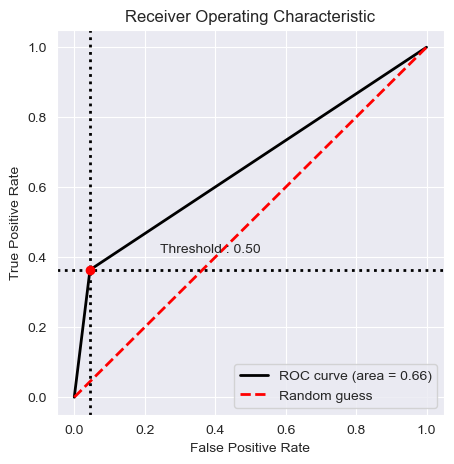

In [76]:
from plot_metric.functions import BinaryClassification
bc = BinaryClassification(y_test, y_pred, labels=["0", "1"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

# DecisionTree

In [149]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

In [150]:
accuracy_score(y_test, y_pred)

0.7326666666666667

In [152]:
from sklearn.feature_selection import RFECV
clf = DecisionTreeClassifier(random_state=42)
rfecv = RFECV(estimator=clf, cv=3)
rfecv.fit(X_train, y_train)
print("Optimal number of features: ", rfecv.n_features_)

Optimal number of features:  15


In [153]:
selected_features = [X.columns[i] for i in range(len(X.columns)) if rfecv.support_[i]]
print("Selected features: ", selected_features)

Selected features:  ['LIMIT_BAL', 'AGE', 'BILL_AMT2', 'BILL_AMT4', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'SEX_M', 'EDUCATION_Graduate school', 'PAY_0_2', 'PAY_2_2']


In [154]:
X_train_selected = rfecv.transform(X_train)
X_test_selected = rfecv.transform(X_test)
dt = DecisionTreeClassifier()
dt.fit(X_train_selected, y_train)
y_pred = dt.predict(X_test_selected)
accuracy_score(y_test, y_pred)

0.7398333333333333

In [ ]:
DecisionTree - Randomized CV

In [155]:
param_grid = {
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
}

classifier = DecisionTreeClassifier()
randomized_cv = RandomizedSearchCV(estimator=classifier, param_distributions=param_grid, cv=5, n_iter=10)
randomized_cv.fit(X_train_selected, y_train)

# Print the best hyperparameters and mean cross-validated score
print("Best Hyperparameters:", randomized_cv.best_params_)
print("Best Score:", randomized_cv.best_score_)

Best Hyperparameters: {'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 5}
Best Score: 0.8156666666666667


In [156]:
best_dt = DecisionTreeClassifier(**randomized_cv.best_params_)
best_dt.fit(X_train_selected, y_train)
y_pred = best_dt.predict(X_test_selected)
accuracy_score(y_test, y_pred)

0.8245

In [157]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, y_pred)
print("Precision:", precision)

recall = recall_score(y_test, y_pred)
print("Recall:", recall)

f1 = f1_score(y_test, y_pred)
print("F1-score:", f1)

Accuracy: 0.8245
Precision: 0.6894409937888198
Recall: 0.34232845026985353
F1-score: 0.45749613601236483


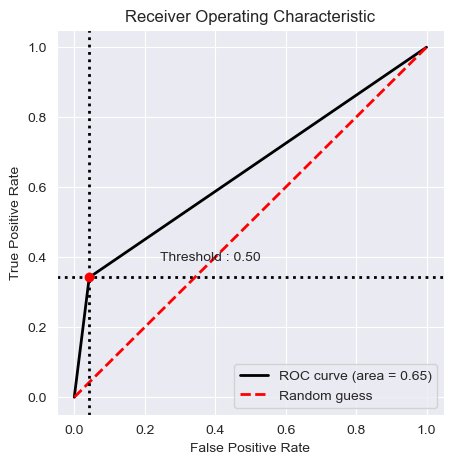

In [86]:
from plot_metric.functions import BinaryClassification
bc = BinaryClassification(y_test, y_pred, labels=["0", "1"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

# Sampling

In [21]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

In [22]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.545

In [23]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
precision = precision_score(y_test, y_pred)
print("Precision:", precision)
recall = recall_score(y_test, y_pred)
print("Recall:", recall)
f1 = f1_score(y_test, y_pred)
print("F1-score:", f1)

Accuracy: 0.545
Precision: 0.28464081755335136
Recall: 0.7301464919043947
F1-score: 0.40960207612456745


In [24]:
from imblearn.under_sampling import RandomUnderSampler
under_sampler = RandomUnderSampler()
X_train, y_train = under_sampler.fit_resample(X_train, y_train)
pd.Series(y_train).value_counts()

0    18661
1    18661
Name: default, dtype: int64

In [25]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.545

In [26]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
precision = precision_score(y_test, y_pred)
print("Precision:", precision)
recall = recall_score(y_test, y_pred)
print("Recall:", recall)
f1 = f1_score(y_test, y_pred)
print("F1-score:", f1)

Accuracy: 0.545
Precision: 0.28464081755335136
Recall: 0.7301464919043947
F1-score: 0.40960207612456745


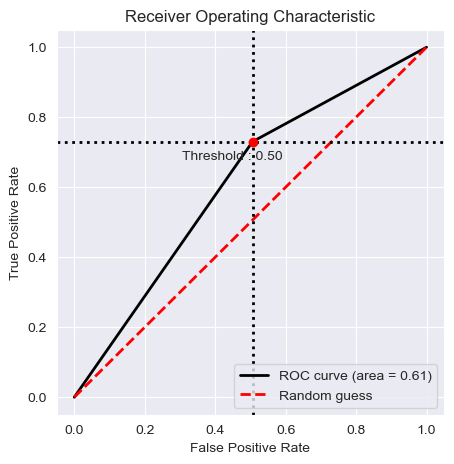

In [27]:
from plot_metric.functions import BinaryClassification
bc = BinaryClassification(y_test, y_pred, labels=["0", "1"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()